In [38]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import os
import cv2
import glob

In [39]:
data_dir = '/home/aracely/aitraveling/cities'
labels = ['agra', 'cdmx', 'newyork', 'paris', 'shanhaiguan']
for label in labels:
    image_count = len(glob.glob(data_dir+"/"+label+"/*"))
    print(label+": "+str(image_count))

agra: 166
cdmx: 162
newyork: 443
paris: 248
shanhaiguan: 164


In [40]:
images = {}
for label in labels:
    images[label] = glob.glob(data_dir+"/"+label+"/*")
# imgs_china = glob.glob(data_dir+"/china/*")
# imgs_india = glob.glob(data_dir+"/india/*")
# imgs_mexico = glob.glob(data_dir+"/mexico/*")

In [41]:
print(len(images["agra"]))

166


## Load data using a Keras utility

### Create a dataset

In [42]:
batch_size = 32
img_height = 180
img_width = 180

In [43]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1183 files belonging to 5 classes.
Using 947 files for training.


In [44]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1183 files belonging to 5 classes.
Using 236 files for validation.


In [45]:
class_names = train_ds.class_names
print(class_names)

['agra', 'cdmx', 'newyork', 'paris', 'shanhaiguan']


## Visualize the data

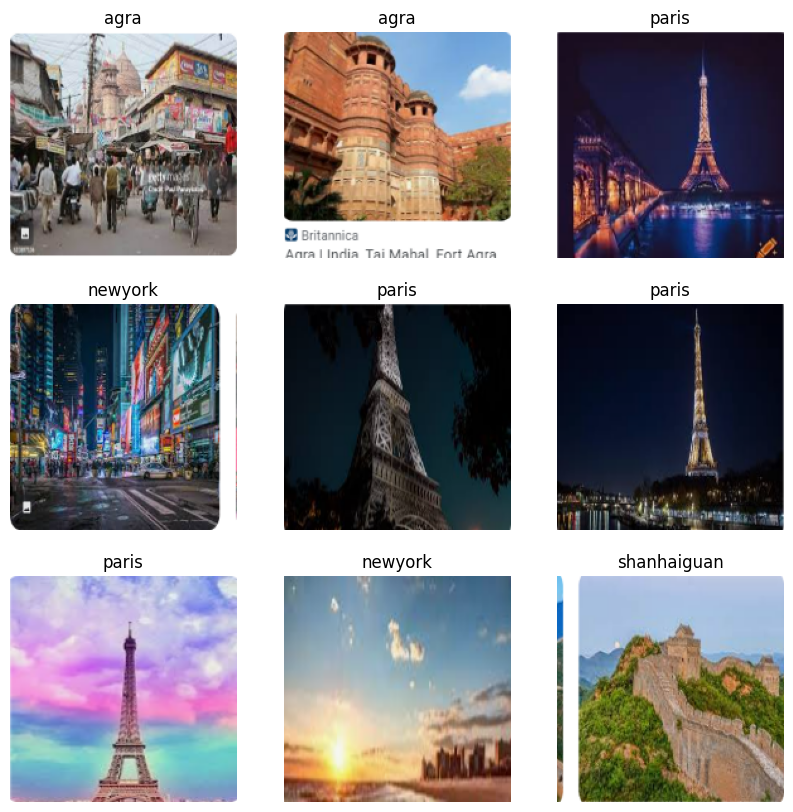

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [47]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## Configure the dataset for performance

In [48]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [49]:
normalization_layer = layers.Rescaling(1./255)

In [50]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99869287


## A basic Keras model

### Create the model

In [51]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

In [52]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

In [53]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

### Train the model

In [54]:
epochs=12
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/12
30/30 [==============================] - 7s 200ms/step - loss: 1.7579 - accuracy: 0.3273 - val_loss: 1.3807 - val_accuracy: 0.4831
Epoch 2/12
30/30 [==============================] - 6s 193ms/step - loss: 1.3166 - accuracy: 0.4826 - val_loss: 1.2177 - val_accuracy: 0.5466
Epoch 3/12
30/30 [==============================] - 6s 195ms/step - loss: 1.0546 - accuracy: 0.6072 - val_loss: 1.1592 - val_accuracy: 0.5466
Epoch 4/12
30/30 [==============================] - 6s 196ms/step - loss: 0.8979 - accuracy: 0.6853 - val_loss: 1.2130 - val_accuracy: 0.5763
Epoch 5/12
30/30 [==============================] - 6s 193ms/step - loss: 0.7261 - accuracy: 0.7350 - val_loss: 1.2855 - val_accuracy: 0.5720
Epoch 6/12
30/30 [==============================] - 6s 195ms/step - loss: 0.5808 - accuracy: 0.7888 - val_loss: 1.1467 - val_accuracy: 0.5975
Epoch 7/12
30/30 [==============================] - 6s 193ms/step - loss: 0.4628 - accuracy: 0.8458 - val_loss: 1.1970 - val_accuracy: 0.6186
Epoch 

## Visualize training results

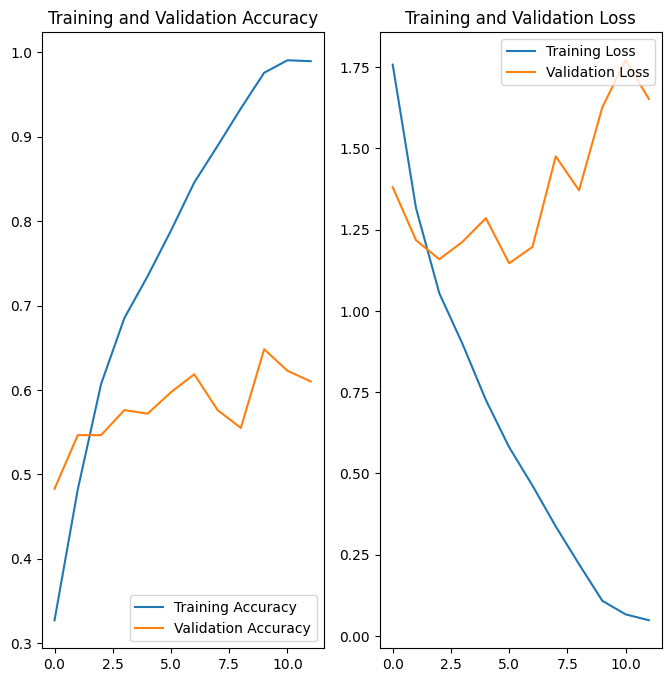

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Data augmentation

In [56]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

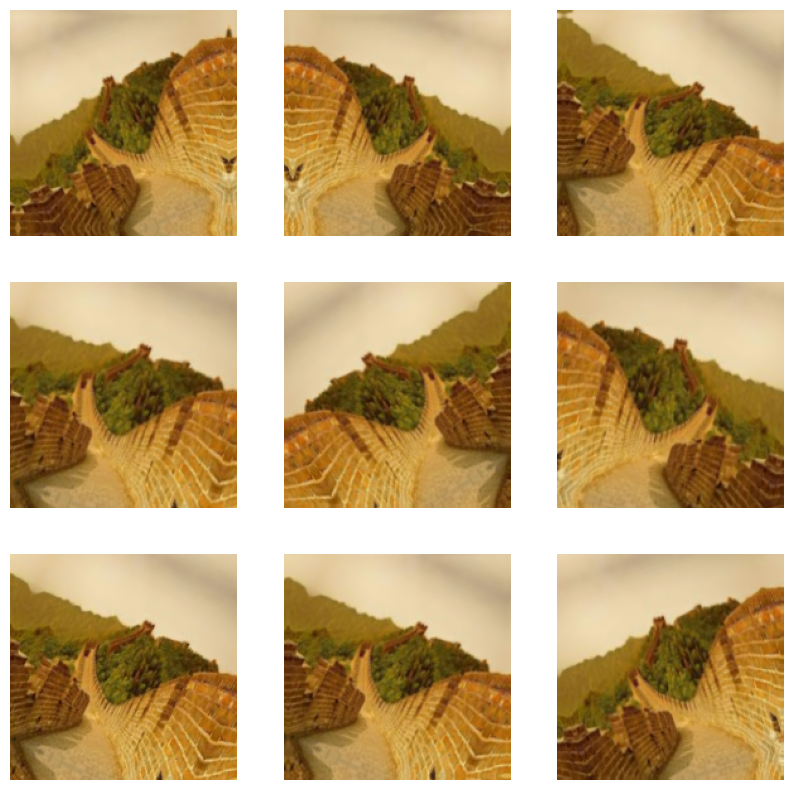

In [57]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [58]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [59]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [60]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

In [61]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
30/30 [==============================] - 8s 235ms/step - loss: 1.5273 - accuracy: 0.3527 - val_loss: 1.3625 - val_accuracy: 0.4703
Epoch 2/15
30/30 [==============================] - 7s 238ms/step - loss: 1.2625 - accuracy: 0.4910 - val_loss: 1.4061 - val_accuracy: 0.4915
Epoch 3/15
30/30 [==============================] - 7s 240ms/step - loss: 1.2447 - accuracy: 0.5037 - val_loss: 1.1886 - val_accuracy: 0.5466
Epoch 4/15
30/30 [==============================] - 7s 237ms/step - loss: 1.1208 - accuracy: 0.5639 - val_loss: 1.1229 - val_accuracy: 0.5678
Epoch 5/15
30/30 [==============================] - 7s 242ms/step - loss: 1.0826 - accuracy: 0.5861 - val_loss: 1.0866 - val_accuracy: 0.5932
Epoch 6/15
30/30 [==============================] - 7s 241ms/step - loss: 0.9852 - accuracy: 0.6262 - val_loss: 1.2921 - val_accuracy: 0.5678
Epoch 7/15
30/30 [==============================] - 7s 241ms/step - loss: 0.9784 - accuracy: 0.6283 - val_loss: 1.3077 - val_accuracy: 0.5678
Epoch 

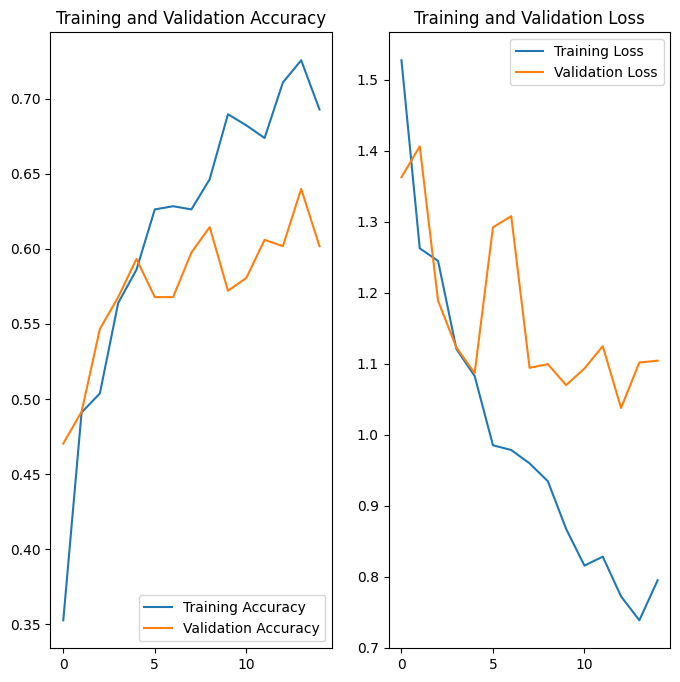

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

In [65]:
data_dir

'/home/aracely/aitraveling/cities'

In [78]:
img = tf.keras.utils.load_img(
    data_dir+'/agra/(1105).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
print()
print(class_names)
# print(type(score))
print(np.array(score))
# img

1/1 [==============================] - 0s 96ms/step
This image most likely belongs to cdmx with a 51.67 percent confidence.

['agra', 'cdmx', 'newyork', 'paris', 'shanhaiguan']
[0.4032548  0.51669925 0.04299314 0.03629418 0.0007586 ]


1/1 [==============================] - 0s 30ms/step
This image most likely belongs to cdmx with a 73.66 percent confidence.

['agra', 'cdmx', 'newyork', 'paris', 'shanhaiguan']
[0.0017483  0.73661685 0.16833535 0.09254213 0.00075735]


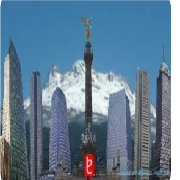

In [80]:
img2 = tf.keras.utils.load_img(
    data_dir+'/cdmx/(10130).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img2)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img2

1/1 [==============================] - 0s 28ms/step
This image most likely belongs to newyork with a 98.33 percent confidence.

['agra', 'cdmx', 'newyork', 'paris', 'shanhaiguan']
[1.2356057e-04 1.4466541e-02 9.8326659e-01 2.1431891e-03 1.3118836e-07]


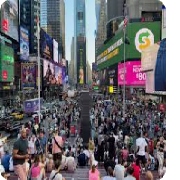

In [82]:
img3 = tf.keras.utils.load_img(
    data_dir+'/newyork/(10237).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img3)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img3

1/1 [==============================] - 0s 24ms/step
This image most likely belongs to paris with a 91.09 percent confidence.

['agra', 'cdmx', 'newyork', 'paris', 'shanhaiguan']
[4.3575186e-04 7.6101355e-02 1.2281519e-02 9.1092122e-01 2.6013257e-04]


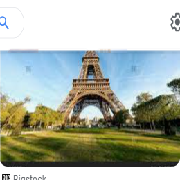

In [85]:
img4 = tf.keras.utils.load_img(
    data_dir+'/paris/(10239).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img4)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img4

1/1 [==============================] - 0s 27ms/step
This image most likely belongs to cdmx with a 67.65 percent confidence.

['agra', 'cdmx', 'newyork', 'paris', 'shanhaiguan']
[0.02434556 0.6764739  0.08922063 0.01477531 0.19518465]


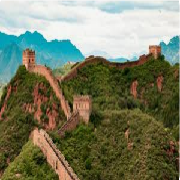

In [88]:
img5 = tf.keras.utils.load_img(
    data_dir+'/shanhaiguan/(10431).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img5)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img5

## Use TensorFlow Lite

### Convert the Keras Sequential model to a TensorFlow Lite model


In [35]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp20isgsq7/assets


INFO:tensorflow:Assets written to: /tmp/tmp20isgsq7/assets
2024-02-19 20:05:06.057674: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-19 20:05:06.057749: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-19 20:05:06.059292: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp20isgsq7
2024-02-19 20:05:06.062487: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-19 20:05:06.062508: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp20isgsq7
2024-02-19 20:05:06.070681: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-02-19 20:05:06.072549: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-19 20:05:06.159079: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

### Run the TensorFlow Lite model

In [36]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [37]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

In [38]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [39]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

1/1 [==============================] - 0s 29ms/step
This image most likely belongs to china with a 57.11 percent confidence.


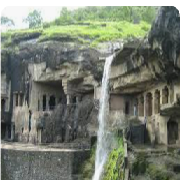

In [40]:
img10 = tf.keras.utils.load_img(
    data_dir2+'testindia.png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img10)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)
img10

In [41]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to china with a 57.11 percent confidence.
